# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [52]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

# import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [98]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv(r"C:\Users\Manoj Kumar Panicker\python Again\Files\telecom-churn-case-study-hackathon-c-61\train.csv")
unseen = pd.read_csv(r"C:\Users\Manoj Kumar Panicker\python Again\Files\telecom-churn-case-study-hackathon-c-61\test.csv")
sample = pd.read_csv(r"C:\Users\Manoj Kumar Panicker\python Again\Files\telecom-churn-case-study-hackathon-c-61\sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

unseen_old = unseen.copy()

print(data.shape)
print(unseen.shape)
print(sample.shape)
#print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)


In [99]:
#unseen = unseen.merge(sample, on='id', how='left')

In [100]:
unseen.shape

(30000, 171)

In [101]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [102]:
data.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

## Creating Function for Pipeline

In [103]:
# dropping 
def drop_null_all(df,unseen_df,axs):
    df.dropna(how='all', axis=axs,inplace =True)
    unseen_df.dropna(how='all', axis=axs,inplace =True)
    
# Dropping where more than 70% values are Null   
def drop_col_most_Null(df,unseen_df):
    drop_col = []
    for i in df.columns:
        x = round((df[i].isnull().sum()/len(data))*100,2)
        if x >= 70:
            #print("Column name is:",i,"and null % is:",x)
            drop_col += [i]
    #print(drop_col)
    df.drop(drop_col,axis=1,inplace=True)
    unseen_df.drop(drop_col,axis=1,inplace=True)

# dropping columns where only one uique value is there in column
def drop_One_Val_Col(df,unseen_df):
    drop_col = []
    for i in df.columns:
        x = df[i].nunique()
        if x == 1:
            #print("Column name is:",i,"and unique value is:",x)
            drop_col += [i]
    #print(drop_col)
    df.drop(drop_col,axis=1,inplace=True)
    unseen_df.drop(drop_col,axis=1,inplace=True)

# now dropping where each value contribution in a column is more than 80%
def drop_one_val_contribution(df,unseen_df):
    drop_col = []
    for i in df.columns:
        x = df[i].value_counts()
        value_count= len(x)
        for j in list(x):
            if j >= len(df)*0.80 and value_count > 10:
                #print("Column name is:",i,"and value count is:",value_count,'and Max contribution is',j)
                drop_col += [i]
    #print(drop_col)
    df.drop(drop_col,axis=1,inplace=True)
    unseen_df.drop(drop_col,axis=1,inplace=True)

# Extracting Date part from date column to convert all columns into numeric
def extract_date_part(df,unseen_df):
    df['date_of_last_rech_6'] = df['date_of_last_rech_6'].str.replace('/','').str[2:4].astype(float)
    df['date_of_last_rech_7'] = df['date_of_last_rech_7'].str.replace('/','').str[2:4].astype(float)
    df['date_of_last_rech_8'] = df['date_of_last_rech_8'].str.replace('/','').str[2:4].astype(float)
    df.drop(['id'],axis=1,inplace=True)
    
    unseen_df['date_of_last_rech_6'] = unseen_df['date_of_last_rech_6'].str.replace('/','').str[2:4].astype(float)
    unseen_df['date_of_last_rech_7'] = unseen_df['date_of_last_rech_7'].str.replace('/','').str[2:4].astype(float)
    unseen_df['date_of_last_rech_8'] = unseen_df['date_of_last_rech_8'].str.replace('/','').str[2:4].astype(float)
    unseen_df.drop(['id'],axis=1,inplace=True)


def skew_control_data(df,df2):
    for i in df.columns:
        skw = round(df[i].skew(axis = 0, skipna = True),2)
        corr = round(df[i].corr(df['churn_probability']),2)
        if skw > 1 and (corr >0 and corr < 0.65):
            df[i] = round(np.sqrt(df[i][np.isfinite(df[i])]),2)
            df2[i] = round(np.sqrt(df2[i][np.isfinite(df2[i])]),2)
            
            
    

# Replacing Null values with mean   
def replace_null(df):
    for i in df.columns:
        mean_val = round(df[i].mean(),2)
        #print('Column is',i,'mean is ',mean_val)
        df[i].fillna(value=mean_val, inplace=True)
        
# Handling Outlier
def outlier_handling(df):
    for i in df.columns:
    
        mean_val = round(df[i].mean(),2)
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.85)

        # Calculate Interquartile Range (IQR)
        IQR = Q3 - Q1
        # Define lower and upper bounds
        lower_bound = round((Q1 - 1.5 * IQR),2)
        upper_bound = round((Q3 + 1.5 * IQR),2)
        # Remove outliers based on lower & upper bounds    
    
        if upper_bound > 0:
            #df[i] = np.where((df[i] < lower_bound) , lower_bound, df[i] )
            df[i] = np.where((df[i] > upper_bound) ,upper_bound , df[i] )
            #print('Column Name is',i,'Upper bound ',upper_bound,'Replaced Value Count',len(data[data[i]==upper_bound]))




In [104]:
# to display pipeline diagram
from sklearn import set_config
set_config(display='diagram')

In [105]:
# Creating Pipeline to perform all steps created above
Pipeline([('Drop Null Column', drop_null_all(data,unseen,1)),('Drop Null Rows', drop_null_all(data,unseen,0)),
            ('Drop where >70% Observations are Null', drop_col_most_Null(data,unseen)),('Drop Columns with 1 unique value', drop_One_Val_Col(data,unseen)),
            ('Drop where one value contribution is >80% ', drop_one_val_contribution(data,unseen)),('Extract Date to convert Numeric', extract_date_part(data,unseen)),
            ('Skew Handling in data',skew_control_data(data,unseen)),
            ('Replace Null from Data',replace_null(data)),
            ('Replace Null from Unseen',replace_null(unseen)),
            ('Outlier Handling in Data',outlier_handling(data)),('Outlier Handling in unseen',outlier_handling(unseen))])


Pipeline(steps=[('Drop Null Column', None), ('Drop Null Rows', None),
                ('Drop where >70% Observations are Null', None),
                ('Drop Columns with 1 unique value', None),
                ('Drop where one value contribution is >80% ', None),
                ('Extract Date to convert Numeric', None),
                ('Skew Handling in data', None),
                ('Replace Null from Data', None),
                ('Replace Null from Unseen', None),
                ('Outlier Handling in Data', None),
                ('Outlier Handling in unseen', None)])

In [106]:
print(data.shape)
print(unseen.shape)

(69999, 99)
(30000, 98)


In [107]:
# To check skewness below code

In [108]:
X = data.copy()
y = X.pop('churn_probability')
X.shape, y.shape

((69999, 98), (69999,))

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52499, 98), (17500, 98), (52499,), (17500,))

### PCA

In [110]:
pca = PCA(n_components =15,random_state=42)
pca.fit(X_train)
pca.components_

array([[ 1.06872513e-03,  3.31641603e-02,  3.66080952e-02, ...,
         9.43088065e-06,  7.60665302e-06,  9.78118909e-01],
       [ 6.01651040e-03,  2.79987907e-01,  2.86425117e-01, ...,
         1.87099537e-05,  4.83196309e-05, -1.36783495e-01],
       [ 2.00589876e-03, -1.48846791e-02, -6.24680968e-02, ...,
         4.35778058e-05,  4.50868697e-05, -1.51189047e-01],
       ...,
       [-9.13378504e-03, -1.44405664e-01,  4.59173905e-03, ...,
         1.86132975e-04,  7.78620162e-05, -1.05034946e-02],
       [ 4.97883346e-03,  2.09939263e-03,  1.95704524e-02, ...,
        -9.13624885e-05, -1.64085968e-04, -1.82842714e-04],
       [-6.37715858e-03, -1.21911538e-01,  1.83590999e-02, ...,
         9.20153812e-05, -1.04449864e-04, -7.13376810e-05]])

In [111]:
pca.explained_variance_ratio_

array([0.45199624, 0.28774276, 0.08858526, 0.03656747, 0.03134751,
       0.02187431, 0.01484295, 0.0105061 , 0.00804503, 0.00560911,
       0.00520432, 0.00464298, 0.00378212, 0.00332094, 0.00286648])

<BarContainer object of 15 artists>

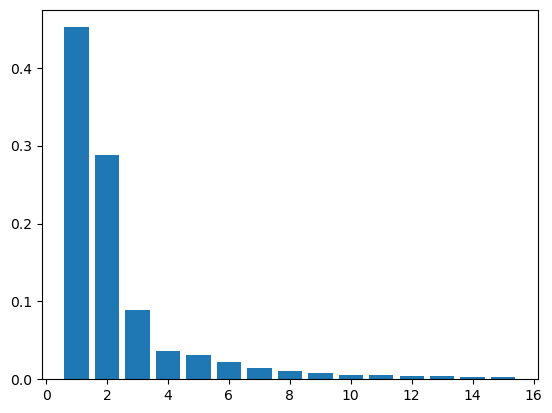

In [112]:
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)

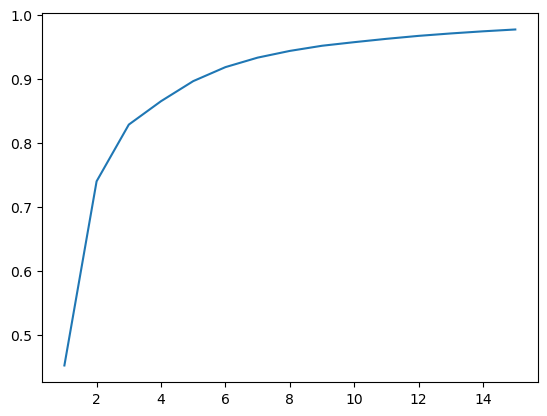

In [113]:
var_cum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1,len(var_cum)+1),var_cum)

In [114]:
pca.explained_variance_ratio_.sum()

0.9769335954530768

In [115]:
#loading = pd.DataFrame(pca.components_.T,columns=[f'PC{i+1}' for i in range(pca.n_components_)],index=X_train.columns)

In [153]:
loading = pd.DataFrame(pca.components_.T,columns=[f'PC{i+1}' for i in range(pca.explained_variance_ratio_)],index=X_train.columns)

TypeError: only integer scalar arrays can be converted to a scalar index

In [116]:
loading

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
arpu_6,0.001069,0.006017,0.002006,0.007319,0.003096,-0.000138,0.002845,0.012598,0.003223,0.009615,0.000484,-0.008946,-0.009134,0.004979,-0.006377
arpu_7,0.033164,0.279988,-0.014885,0.375152,0.174247,-0.180906,-0.016817,-0.009400,0.152088,-0.065213,-0.012825,-0.036900,-0.144406,0.002099,-0.121912
arpu_8,0.036608,0.286425,-0.062468,-0.160128,0.406235,-0.030010,-0.008683,0.057156,-0.115804,-0.112472,0.051495,0.076732,0.004592,0.019570,0.018359
onnet_mou_6,0.000314,0.004761,-0.001477,0.002221,-0.005799,-0.002478,0.019237,0.006745,0.001143,0.005362,0.000194,-0.005850,-0.014697,-0.003668,0.000774
onnet_mou_7,0.000351,0.006203,-0.003165,0.003634,-0.007066,-0.005710,0.020420,-0.003560,-0.002437,0.001969,-0.005179,-0.002916,-0.009807,-0.006526,-0.004166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
monthly_2g_6,0.000007,0.000012,0.000053,0.000051,0.000192,-0.000076,-0.000008,0.000034,0.000029,0.000348,-0.000115,-0.000174,0.000221,-0.000114,-0.000074
monthly_2g_7,0.000008,0.000020,0.000049,0.000110,0.000244,-0.000120,-0.000028,-0.000016,0.000202,0.000254,-0.000058,-0.000046,0.000292,-0.000105,0.000108
monthly_2g_8,0.000009,0.000019,0.000044,0.000005,0.000292,-0.000083,-0.000018,0.000028,-0.000155,0.000223,-0.000076,-0.000146,0.000186,-0.000091,0.000092
monthly_3g_6,0.000008,0.000048,0.000045,0.000128,0.000380,-0.000120,-0.000031,0.000114,0.000165,0.000504,-0.000295,-0.000286,0.000078,-0.000164,-0.000104


In [117]:
loading.sort_values(by=['PC1'],ascending = False).head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
aon,0.978119,-0.136783,-0.151189,0.002687,-0.021656,-0.023510,-0.013368,0.003683,0.000833,-0.017891,0.003066,0.003744,-0.010503,-0.000183,-0.000071
total_ic_mou_7,0.061033,0.118931,0.338350,-0.042558,-0.117024,-0.269524,-0.086541,-0.116389,-0.170699,0.171618,-0.179759,0.507338,0.002988,0.157052,-0.054633
total_ic_mou_8,0.060554,0.121561,0.305999,-0.211656,-0.023548,-0.200646,-0.105229,-0.386907,0.003856,0.200604,0.324089,-0.138576,-0.227444,0.278475,0.195315
total_ic_mou_6,0.059831,0.093173,0.353221,-0.059109,-0.112875,-0.195334,0.012294,0.489353,-0.001745,0.150165,0.312148,0.076531,-0.070496,0.008334,-0.350951
loc_ic_mou_7,0.052084,0.085169,0.292016,-0.042288,-0.086776,-0.094597,-0.015537,-0.083340,-0.067175,-0.148111,-0.413625,0.165270,0.150352,-0.264659,0.141996
loc_ic_mou_6,0.051224,0.069623,0.299952,-0.055891,-0.078971,-0.059462,0.068334,0.398560,0.063826,-0.155926,0.052106,-0.159575,0.108491,-0.272574,0.075455
loc_ic_mou_8,0.050590,0.084635,0.269158,-0.149009,-0.033790,-0.047625,-0.030313,-0.302023,0.128329,-0.106969,0.024955,-0.392425,-0.089004,-0.221441,0.114198
loc_og_mou_8,0.047826,0.115056,0.125322,-0.053312,0.052305,0.351688,0.153778,-0.189408,0.134094,0.045719,0.093841,0.057684,-0.025767,-0.176278,-0.361916
loc_og_mou_7,0.047605,0.116714,0.146251,0.104855,-0.015133,0.319862,0.165966,-0.095775,-0.032037,0.029358,-0.181011,0.179703,-0.128499,-0.028673,0.015562
loc_og_mou_6,0.047322,0.097102,0.165340,0.068163,-0.003689,0.342672,0.237694,0.233965,0.080456,0.068471,0.022099,0.010506,-0.217014,0.209808,0.453261


### aon is most significant variable 

In [118]:
loading.sort_values(by=['PC2'],ascending = False).head(12)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
total_og_mou_8,0.027473,0.405537,-0.224892,-0.395611,-0.200961,0.100154,0.182766,-0.052909,0.147335,0.034443,0.197020,0.222344,0.434133,0.063857,0.109331
total_og_mou_7,0.025571,0.404006,-0.150274,0.334938,-0.463488,-0.034668,0.181116,-0.092703,-0.476749,-0.002034,0.163611,-0.223525,0.097629,-0.036791,-0.015812
total_rech_amt_8,0.042486,0.335126,-0.077322,-0.238724,0.522814,-0.035066,-0.004039,0.105919,-0.404555,-0.123988,-0.061273,-0.070537,-0.129332,-0.022435,-0.006720
total_rech_amt_7,0.038299,0.333589,-0.024301,0.462574,0.207101,-0.229784,-0.029364,-0.059455,0.447066,-0.095495,0.077938,0.117589,0.079471,-0.007304,0.094039
arpu_8,0.036608,0.286425,-0.062468,-0.160128,0.406235,-0.030010,-0.008683,0.057156,-0.115804,-0.112472,0.051495,0.076732,0.004592,0.019570,0.018359
arpu_7,0.033164,0.279988,-0.014885,0.375152,0.174247,-0.180906,-0.016817,-0.009400,0.152088,-0.065213,-0.012825,-0.036900,-0.144406,0.002099,-0.121912
offnet_mou_7,0.019594,0.207393,-0.018245,0.191591,-0.187017,0.225339,-0.464582,0.056326,-0.164315,0.020502,-0.126849,-0.060144,-0.204652,-0.027168,-0.018922
offnet_mou_8,0.019501,0.207246,-0.053964,-0.158941,-0.063832,0.299334,-0.488800,0.051436,0.186223,0.046699,0.078063,0.064654,-0.012983,-0.173839,-0.122685
std_og_mou_8,-0.031706,0.191974,-0.299483,-0.268989,-0.258593,-0.227652,-0.089957,0.175280,0.242612,0.017412,-0.320703,-0.090268,-0.213030,0.091183,0.104458
total_ic_mou_8,0.060554,0.121561,0.305999,-0.211656,-0.023548,-0.200646,-0.105229,-0.386907,0.003856,0.200604,0.324089,-0.138576,-0.227444,0.278475,0.195315


### total_og_mou_7,total_og_mou_8,total_rech_amt_7,total_og_mou_6,total_rech_amt_8,total_rech_amt_6,arpu_7,arpu_8,arpu_6

In [119]:
loading.sort_values(by=['PC3'],ascending = False).head(12)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
total_ic_mou_6,0.059831,0.093173,0.353221,-0.059109,-0.112875,-0.195334,0.012294,0.489353,-0.001745,0.150165,0.312148,0.076531,-0.070496,0.008334,-0.350951
total_ic_mou_7,0.061033,0.118931,0.338350,-0.042558,-0.117024,-0.269524,-0.086541,-0.116389,-0.170699,0.171618,-0.179759,0.507338,0.002988,0.157052,-0.054633
total_ic_mou_8,0.060554,0.121561,0.305999,-0.211656,-0.023548,-0.200646,-0.105229,-0.386907,0.003856,0.200604,0.324089,-0.138576,-0.227444,0.278475,0.195315
loc_ic_mou_6,0.051224,0.069623,0.299952,-0.055891,-0.078971,-0.059462,0.068334,0.398560,0.063826,-0.155926,0.052106,-0.159575,0.108491,-0.272574,0.075455
loc_ic_mou_7,0.052084,0.085169,0.292016,-0.042288,-0.086776,-0.094597,-0.015537,-0.083340,-0.067175,-0.148111,-0.413625,0.165270,0.150352,-0.264659,0.141996
loc_ic_mou_8,0.050590,0.084635,0.269158,-0.149009,-0.033790,-0.047625,-0.030313,-0.302023,0.128329,-0.106969,0.024955,-0.392425,-0.089004,-0.221441,0.114198
loc_ic_t2m_mou_6,0.032156,0.044148,0.180498,-0.024549,-0.040434,0.000342,-0.006761,0.253079,0.058804,-0.200636,-0.050275,-0.214365,0.213224,0.145734,-0.060809
loc_ic_t2m_mou_7,0.032407,0.054023,0.174642,-0.015002,-0.046264,-0.018318,-0.064436,-0.042585,-0.023357,-0.201150,-0.334605,-0.021357,0.241796,0.146071,-0.052017
loc_og_mou_6,0.047322,0.097102,0.165340,0.068163,-0.003689,0.342672,0.237694,0.233965,0.080456,0.068471,0.022099,0.010506,-0.217014,0.209808,0.453261
loc_ic_t2m_mou_8,0.032119,0.054157,0.163572,-0.086226,-0.013517,0.007164,-0.074021,-0.177408,0.100834,-0.167694,-0.055669,-0.351263,0.097039,0.133528,-0.079224


In [120]:
loading.sort_values(by=['PC4'],ascending = False).head(12)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
total_rech_amt_7,0.038299,0.333589,-0.024301,0.462574,0.207101,-0.229784,-0.029364,-0.059455,0.447066,-0.095495,0.077938,0.117589,0.079471,-0.007304,0.094039
arpu_7,0.033164,0.279988,-0.014885,0.375152,0.174247,-0.180906,-0.016817,-0.009400,0.152088,-0.065213,-0.012825,-0.036900,-0.144406,0.002099,-0.121912
total_og_mou_7,0.025571,0.404006,-0.150274,0.334938,-0.463488,-0.034668,0.181116,-0.092703,-0.476749,-0.002034,0.163611,-0.223525,0.097629,-0.036791,-0.015812
offnet_mou_7,0.019594,0.207393,-0.018245,0.191591,-0.187017,0.225339,-0.464582,0.056326,-0.164315,0.020502,-0.126849,-0.060144,-0.204652,-0.027168,-0.018922
loc_og_mou_7,0.047605,0.116714,0.146251,0.104855,-0.015133,0.319862,0.165966,-0.095775,-0.032037,0.029358,-0.181011,0.179703,-0.128499,-0.028673,0.015562
max_rech_amt_7,0.019141,0.045985,0.014088,0.088283,0.089786,-0.033475,-0.003011,-0.010977,0.172986,0.333956,-0.073687,-0.041566,0.218331,-0.030399,0.084611
loc_og_t2m_mou_7,0.030482,0.072362,0.096461,0.069621,-0.001185,0.219946,0.001633,-0.040190,-0.003031,-0.047520,-0.191717,0.046733,-0.021793,0.215825,-0.090028
loc_og_mou_6,0.047322,0.097102,0.165340,0.068163,-0.003689,0.342672,0.237694,0.233965,0.080456,0.068471,0.022099,0.010506,-0.217014,0.209808,0.453261
last_day_rch_amt_7,0.012201,0.034333,0.006612,0.051806,0.048676,-0.009731,-0.000529,-0.015139,0.140579,0.244407,-0.056058,-0.024101,0.198654,-0.016297,0.085977
max_rech_amt_6,0.018307,0.032294,0.023543,0.048596,0.068737,0.015740,0.016057,0.072885,0.016136,0.429913,-0.143154,-0.198606,0.064378,-0.024647,-0.125953


In [121]:
loading.sort_values(by=['PC5'],ascending = False).head(12)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
total_rech_amt_8,0.042486,0.335126,-0.077322,-0.238724,0.522814,-0.035066,-0.004039,0.105919,-0.404555,-0.123988,-0.061273,-0.070537,-0.129332,-0.022435,-0.006720
arpu_8,0.036608,0.286425,-0.062468,-0.160128,0.406235,-0.030010,-0.008683,0.057156,-0.115804,-0.112472,0.051495,0.076732,0.004592,0.019570,0.018359
total_rech_amt_7,0.038299,0.333589,-0.024301,0.462574,0.207101,-0.229784,-0.029364,-0.059455,0.447066,-0.095495,0.077938,0.117589,0.079471,-0.007304,0.094039
arpu_7,0.033164,0.279988,-0.014885,0.375152,0.174247,-0.180906,-0.016817,-0.009400,0.152088,-0.065213,-0.012825,-0.036900,-0.144406,0.002099,-0.121912
max_rech_amt_8,0.021701,0.050965,0.006165,-0.028487,0.154659,0.004823,0.005195,0.032053,-0.139895,0.353966,-0.159793,-0.167850,0.124372,-0.044621,0.052241
last_day_rch_amt_8,0.017185,0.031822,0.008239,-0.021391,0.100064,0.016629,0.008904,0.020873,-0.087432,0.267461,-0.126960,-0.143164,0.143089,-0.045959,0.072797
max_rech_amt_7,0.019141,0.045985,0.014088,0.088283,0.089786,-0.033475,-0.003011,-0.010977,0.172986,0.333956,-0.073687,-0.041566,0.218331,-0.030399,0.084611
max_rech_amt_6,0.018307,0.032294,0.023543,0.048596,0.068737,0.015740,0.016057,0.072885,0.016136,0.429913,-0.143154,-0.198606,0.064378,-0.024647,-0.125953
loc_og_mou_8,0.047826,0.115056,0.125322,-0.053312,0.052305,0.351688,0.153778,-0.189408,0.134094,0.045719,0.093841,0.057684,-0.025767,-0.176278,-0.361916
last_day_rch_amt_7,0.012201,0.034333,0.006612,0.051806,0.048676,-0.009731,-0.000529,-0.015139,0.140579,0.244407,-0.056058,-0.024101,0.198654,-0.016297,0.085977


### std_og_mou_8,std_og_mou_7

In [122]:
from sklearn.decomposition import IncrementalPCA

In [123]:
pca = PCA(n_components =15,random_state=42)

In [124]:
X_train_PCA = pca.fit_transform(X_train)

In [125]:
X_train_PCA.shape

(52499, 15)

In [126]:
# pca_final = IncrementalPCA(n_components=15)
# X_train_pca = pca_final.fit_transform(X_train)

In [127]:
corrmat = np.corrcoef(X_train_PCA.transpose())

<Axes: >

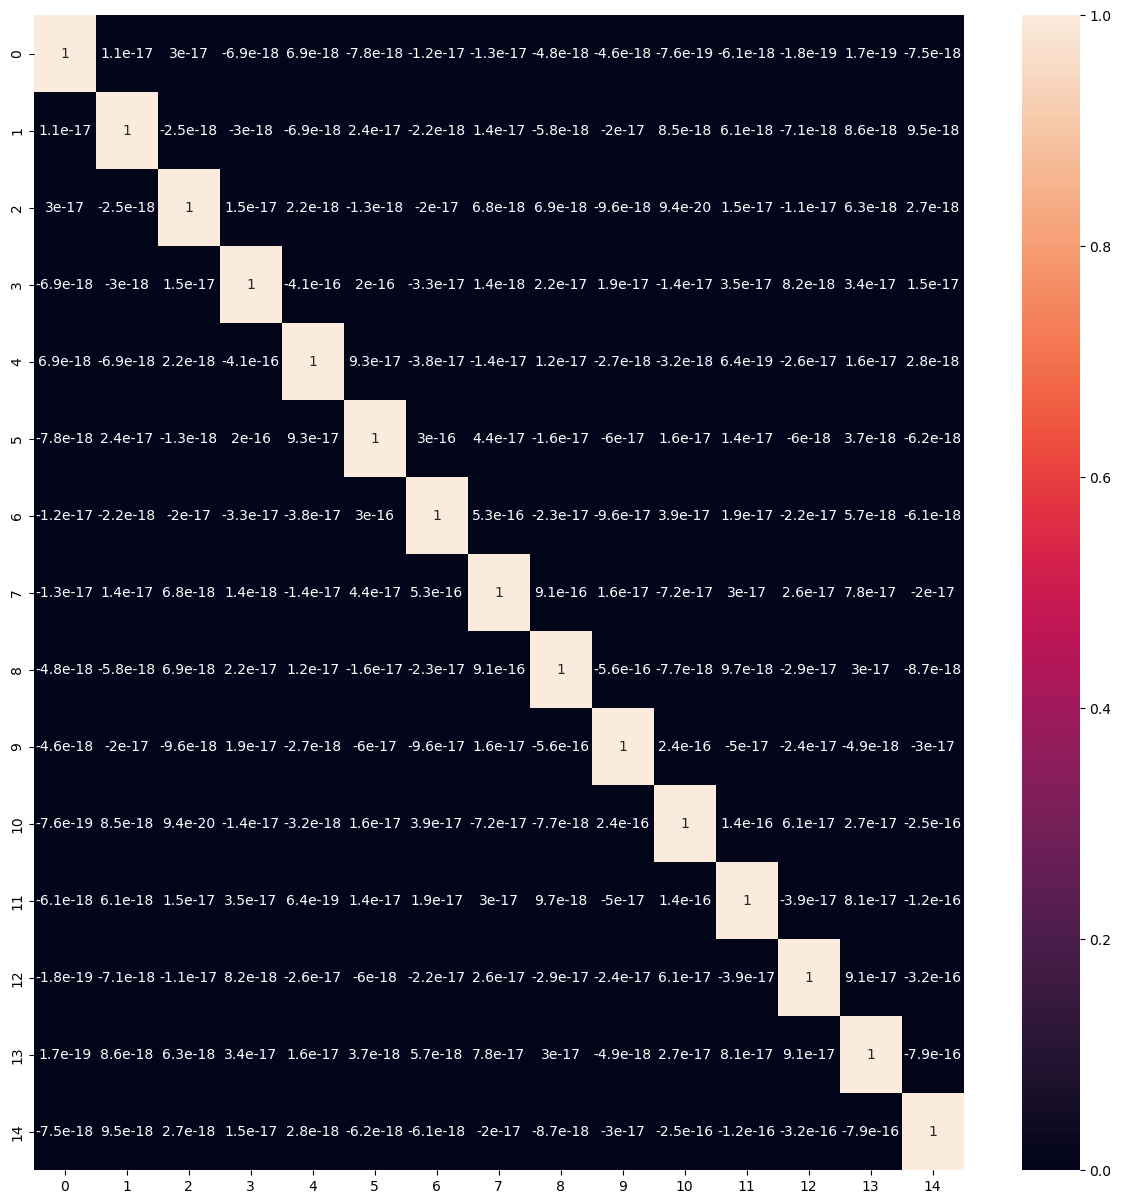

In [128]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

### Scaling and LogisticRegression

In [129]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
steps = [('Standard Scaler',StandardScaler()),('Logistic Regression CV',
                                               LogisticRegressionCV(cv=3,max_iter=1000,random_state=42))]
                                                                    #,solver='saga',penalty='l2'))]

In [130]:
pipe = Pipeline(steps)
pipe

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('Logistic Regression CV',
                 LogisticRegressionCV(cv=3, max_iter=1000, random_state=42))])

In [131]:
#scaler.fit_transform(data)

In [132]:
## Applying PCA transformation on test set
X_test_pca = pca.transform(X_test)
X_test_pca.shape

(17500, 15)

In [133]:
## Applying PCA transformation on Unseen set
unseen_pca = pca.transform(unseen)
unseen_pca.shape

(30000, 15)

In [134]:
print(X_train_PCA.shape)
print(X_test_pca.shape)
print(unseen_pca.shape)

(52499, 15)
(17500, 15)
(30000, 15)


## Logistic Regression

In [135]:
pipe.fit(X_train_PCA,y_train)

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('Logistic Regression CV',
                 LogisticRegressionCV(cv=3, max_iter=1000, random_state=42))])

In [136]:
pred_probs_test= pipe.predict(X_test_pca) #X_test_pca
pred_probs_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [137]:
from sklearn import metrics

### Accuracy Score ---> Accuracy is simply the ratio of correct prediction

In [138]:
round(metrics.accuracy_score(y_test, pred_probs_test),2)

0.93

### ROC Score --> ROC is relation between True positive rate and false Positive rate

In [139]:
round(metrics.roc_auc_score(y_test, pred_probs_test),2) 

0.7

In [140]:
confusion2 = metrics.confusion_matrix(y_test, pred_probs_test)
confusion2

array([[15549,   199],
       [ 1027,   725]], dtype=int64)

## Support Vectore Machine SVM

In [282]:
from sklearn.svm import SVC

In [283]:
steps_SVC = [('Standard Scaler',StandardScaler()),('SVC',SVC())]

In [284]:
pipe_SVC = Pipeline(steps_SVC)
pipe_SVC

Pipeline(steps=[('Standard Scaler', StandardScaler()), ('SVC', SVC())])

In [285]:
pipe_SVC.fit(X_train_PCA,y_train)

Pipeline(steps=[('Standard Scaler', StandardScaler()), ('SVC', SVC())])

In [281]:
pred_SVC= pipe_SVC.predict(X_test_pca) #X_test_pca
pred_SVC

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [286]:
pred_unseen_SVC= pipe_SVC.predict(X_test_pca) #X_test_pca
pred_unseen_SVC

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### ROC Score --> ROC is relation between True positive rate and false Positive rate

In [411]:
round(metrics.roc_auc_score(y_test, pred_SVC),2) 

0.7

### Accuracy Score ---> Accuracy is simply the ratio of correct prediction

In [412]:
round(metrics.accuracy_score(y_test, pred_SVC),2)

0.93

# Random Forest

In [417]:
steps_RF = [('Standard Scaler',StandardScaler()),('RF',RandomForestClassifier())]

In [418]:
pipe_RF = Pipeline(steps_RF)
pipe_RF

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('RF', RandomForestClassifier())])

In [419]:
pipe_RF.fit(X_train_PCA,y_train)
pipe_RF

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('RF', RandomForestClassifier())])

In [420]:
pred_RF= pipe_RF.predict(X_test_pca) #X_test_pca
pred_RF

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### ROC Score --> ROC is relation between True positive rate and false Positive rate

In [421]:
round(metrics.roc_auc_score(y_test, pred_RF),2) 

0.7

### Accuracy Score ---> Accuracy is simply the ratio of correct prediction

In [422]:
round(metrics.accuracy_score(y_test, pred_RF),2)

0.93

## Hyper Parameter in Random Forest

In [423]:
pipe_RF_Tunning = Pipeline([('Standard Scaler',StandardScaler()),('RF',RandomForestClassifier())])
pipe_RF_Tunning

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('RF', RandomForestClassifier())])

In [424]:
grid_param =[
            {'RF':[RandomForestClassifier()],
             'RF__n_estimators': [10],
             'RF__max_depth': [8],
             'RF__min_samples_leaf':[20],
             'RF__max_leaf_nodes':[50]}
            ]

In [425]:
grid_search = GridSearchCV(pipe_RF_Tunning,grid_param,cv=4,verbose=1,n_jobs=-1)

In [426]:
#X_train_PCA_tmp = X_train_PCA[:5]

In [427]:
#y_train_tmp = y_train[:5]

In [428]:
rf_gridsearch_model = grid_search.fit(X_train_PCA,y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


In [429]:
rf_gridsearch_model.best_params_

{'RF': RandomForestClassifier(max_depth=8, max_leaf_nodes=50, min_samples_leaf=20,
                        n_estimators=10),
 'RF__max_depth': 8,
 'RF__max_leaf_nodes': 50,
 'RF__min_samples_leaf': 20,
 'RF__n_estimators': 10}

In [430]:
step_RF_GS = [('Standard Scaler',StandardScaler()),('RF',RandomForestClassifier(max_depth=8,
                                                                                max_leaf_nodes=50, 
                                                                                min_samples_leaf=20,
                                                                                n_estimators=10))]
pipe_RF_GS = Pipeline(step_RF_GS)

In [431]:
pipe_RF_GS

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('RF',
                 RandomForestClassifier(max_depth=8, max_leaf_nodes=50,
                                        min_samples_leaf=20,
                                        n_estimators=10))])

In [432]:
pipe_RF_GS.fit(X_train_PCA,y_train)
pipe_RF_GS

Pipeline(steps=[('Standard Scaler', StandardScaler()),
                ('RF',
                 RandomForestClassifier(max_depth=8, max_leaf_nodes=50,
                                        min_samples_leaf=20,
                                        n_estimators=10))])

In [433]:
pred_RF_GS= pipe_RF_GS.predict(X_test_pca) #X_test_pca
pred_RF_GS

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### ROC Score --> ROC is relation between True positive rate and false Positive rate

In [434]:
round(metrics.roc_auc_score(y_test, pred_RF_GS),2)

0.66

### Accuracy Score ---> Accuracy is simply the ratio of correct prediction

In [435]:
round(metrics.accuracy_score(y_test, pred_RF_GS),2)

0.93

# Conclustion
1. LinearRegression, SVC and Random Forest all are giving same result
2. Hence using LinerRegression Model to predict

In [48]:
pred_probs_unseen = pipe.predict(unseen_pca) #X_test_pca
pred_probs_unseen

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
pred_probs_unseen

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Creating Submission File

In [146]:
unseen_output = pd.DataFrame({'id':unseen_old.id, 'churn_probability':pred_probs_unseen})


In [147]:
unseen_output

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0
...,...,...
29995,99994,0
29996,99995,0
29997,99996,0
29998,99997,0


In [149]:
unseen_output.to_csv('submission_pca_LinearRegression_08jul.csv',index=False)

In [ ]:
# Finding 15 most important variables using RFE

In [154]:
from sklearn.feature_selection import RFE
lnr_mdl = LogisticRegression() # RFE does not work with statsmodels hence using sklearn model to fit data, from sklearn.linear_model import LinearRegression
lnr_mdl.fit(X_train,y_train)

rfe = RFE(lnr_mdl, n_features_to_select=15)
rfe = rfe.fit(X_train,y_train)

In [155]:
# getting all columns supported for model 
support_col = X_train.columns[rfe.support_]
support_col

Index(['roam_ic_mou_6', 'roam_og_mou_6', 'std_og_mou_6', 'loc_ic_t2t_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2f_mou_8', 'total_ic_mou_8', 'isd_ic_mou_7', 'isd_ic_mou_8',
       'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'vol_2g_mb_8'],
      dtype='object')

In [156]:
imp = np.abs(loading).sum(axis=1)

In [168]:
imp.head(3)

arpu_6    0.001112
arpu_7    0.023149
arpu_8    0.020673
dtype: float64

In [158]:
imp/=imp.sum()

In [165]:
type(imp)

pandas.core.series.Series

In [167]:
imp.sort_values(ascending = False).head(15)

total_og_mou_8      0.039994
total_ic_mou_8      0.039789
total_og_mou_7      0.038624
std_og_mou_8        0.037486
total_ic_mou_7      0.034216
total_ic_mou_6      0.033517
total_rech_amt_7    0.032914
loc_og_mou_6        0.032260
total_rech_amt_8    0.031156
loc_ic_mou_7        0.030051
onnet_mou_8         0.029529
loc_ic_mou_8        0.029215
offnet_mou_8        0.028982
offnet_mou_7        0.028474
loc_og_mou_8        0.028351
dtype: float64